# Códigos elaborados na palestra "Como engenar modelos de Aprendidizado de Máquina?"
## III SeComp - UTFPR, 2021

# Ataques adversários contra modelos de ML

## **1 -  Carregar uma base padrão para treinamento**

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random

In [2]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [4]:
x_train.shape

(50000, 32, 32, 3)

<Figure size 864x864 with 0 Axes>

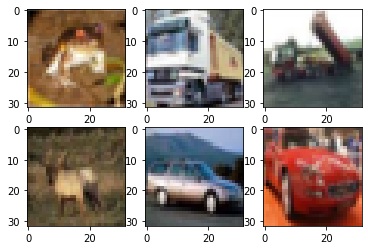

In [5]:
plt.figure(figsize=(12,12))
f, axarr = plt.subplots(2,3)
axarr[0,0].imshow(x_train[0], cmap='gray')
axarr[0,1].imshow(x_train[1], cmap='gray')
axarr[0,2].imshow(x_train[2], cmap='gray')
axarr[1,0].imshow(x_train[3], cmap='gray')
axarr[1,1].imshow(x_train[4], cmap='gray')
axarr[1,2].imshow(x_train[5], cmap='gray')

In [6]:
Y_train = tf.keras.utils.to_categorical(y_train)
Y_test = tf.keras.utils.to_categorical(y_test)

### **Ataque FGSM**

In [13]:
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

In [103]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.backend import repeat_elements, expand_dims, resize_images
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization, Input, Lambda, GlobalAveragePooling2D

In [104]:
base_model = MobileNet(include_top=False, weights='imagenet', input_shape=(32,32,3), classes=Y_train.shape[1])

In [105]:
model = Sequential()

model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())

model.add(Dense(512,activation=('relu'))) 

model.add(Dense(256,activation=('relu'))) 

model.add(Dropout(.3))

model.add(Dense(128,activation=('relu')))

model.add(Dropout(.2))

model.add(Dense(10,activation=('softmax')))

In [106]:
check = tf.keras.callbacks.ModelCheckpoint(filepath='./model.h5', monitor='accuracy', save_best_only=True, mode='max')

In [107]:
early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, verbose=1,mode='max')

In [108]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [109]:
with tf.device('/device:GPU:0'):
    hist = model.fit(x_train, Y_train, batch_size = 32, epochs = 30, validation_split = 0.1, steps_per_epoch=100,validation_data=(x_test, Y_test),
                    callbacks=[check, early])

Epoch 1/30
100/100 [==============================] - 18s 155ms/step - loss: 2.2386 - accuracy: 0.2087 - val_loss: 2.0145 - val_accuracy: 0.2548
Epoch 2/30
100/100 [==============================] - 13s 135ms/step - loss: 1.7821 - accuracy: 0.3503 - val_loss: 1.5670 - val_accuracy: 0.4208
Epoch 3/30
100/100 [==============================] - 13s 134ms/step - loss: 1.5603 - accuracy: 0.4425 - val_loss: 1.3637 - val_accuracy: 0.5130
Epoch 4/30
100/100 [==============================] - 16s 158ms/step - loss: 1.4762 - accuracy: 0.4909 - val_loss: 1.2661 - val_accuracy: 0.5582
Epoch 5/30
100/100 [==============================] - 14s 140ms/step - loss: 1.4115 - accuracy: 0.5213 - val_loss: 1.3779 - val_accuracy: 0.4664
Epoch 6/30
100/100 [==============================] - 14s 138ms/step - loss: 1.3473 - accuracy: 0.5462 - val_loss: 1.2024 - val_accuracy: 0.5878
Epoch 7/30
100/100 [==============================] - 14s 140ms/step - loss: 1.2680 - accuracy: 0.5794 - val_loss: 1.2054 - val_ac

In [290]:
from tensorflow.keras.models import load_model
import numpy as np
import random

In [111]:
m = load_model("./model.h5")

In [112]:
m.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1, 1, 1024)       3228864   
 nal)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 1, 1, 1024)        0         
                                                                 
 flatten_9 (Flatten)         (None, 1024)              0         
                                                                 
 dense_33 (Dense)            (None, 512)               524800    
                                                                 
 dense_34 (Dense)            (None, 256)               131328    
                                                                 
 dropout_25 (Dropout)        (None, 256)               0         
                                                      

In [371]:
def create_adversarial_pattern(input_image, pretrained_model,input_label):
    loss_object = loss_object = tf.keras.losses.CategoricalCrossentropy()
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = pretrained_model(input_image)
        loss = loss_object(input_label, prediction)
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    
    return signed_grad

In [372]:
def build_fgsm(image,label, model, eps):
    img_preprocessing = tf.keras.applications.mobilenet_v2.preprocess_input(tf.cast(image, tf.float32))[None, ...]
    lab = np.reshape(label, (1,10)).astype('int64')
    
    perturbation = create_adversarial_pattern(img_preprocessing, model, lab)
    
    adv_image = img_preprocessing + eps*perturbation
    
    adv_image = tf.clip_by_value(adv_image, 0, 255)
    perturbation = tf.clip_by_value(perturbation, 0, 255)
    
    return adv_image, perturbation

In [407]:
idx = 9663

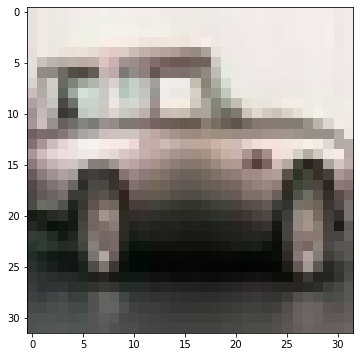

In [408]:
plt.figure(figsize=(6,6))
plt.imshow(x_test[idx])
plt.show()

In [409]:
adv_image, perturbation = build_fgsm(x_test[idx], Y_test[idx], model, 0.0001)

(-0.5, 31.5, 31.5, -0.5)

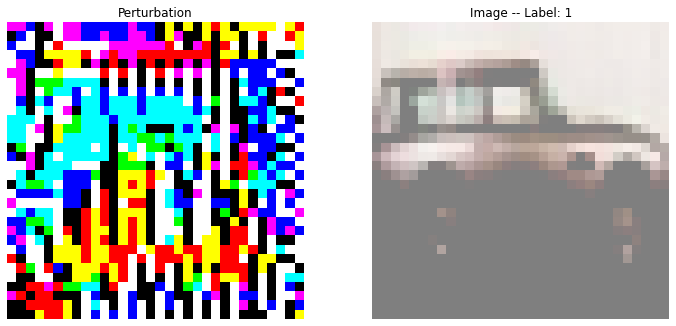

In [410]:
plt.figure(figsize=(12,12))

plt.subplot(221)
plt.imshow(np.reshape(tf.clip_by_value(perturbation, 0, 1), (32,32,3)))
plt.title("Perturbation")
plt.axis('off')

plt.subplot(222)
plt.imshow(np.reshape(tf.clip_by_value(adv_image[0]*0.5 + 0.5, 0,1), (32,32,3)))
plt.title(f"Image -- Label: {np.argmax(Y_test[idx])}")
plt.axis('off')

In [411]:
img = x_test[idx].reshape(1,32,32,3)
pred = m.predict(img)

In [412]:
np.argmax(pred)

1

In [413]:
adv_img = np.reshape(tf.clip_by_value(adv_image[0], 0,1), (1,32,32,3))
pred_adv = m.predict(adv_img)

In [414]:
np.argmax(pred_adv)

0